# FINN Preprocessor

This notebook contains the code to preprocess active fire data for the FINN fire emissions model. 

## 1. User specified configurations

To run the FINN preprocessor, you should specify the following: 

1. `tag_af`: a tag or name for your active fire dataset, e.g., 'modvrs_global_2018'.  See below for guidance for picking `tag_af`.
2. `af_fnames`: a list of file paths to active fire shape files (e.g., downloaded from [FIRMS](https://firms.modaps.eosdis.nasa.gov/)) 
3. `year_rst`: MODIS raster data year to be used for the analysis.  It is recommended to use the data from a year prior to the Active Fire data, as the impact of large fire may affects the VCF product of the year, resulting in smaller estimate of fuel loadings.
4. `filter_persistent_source`: ActiveFire product has inferred hot spot "type" field (0 = presumed vegetation fire, 1 = active volcano, 2 = other static land source, 3 = offshore) ref: Table 9 of [Giglio et al. "MODIS Collection 6 Active Fire Product User’s Guide Revision B" 2018](https://cdn.earthdata.nasa.gov/conduit/upload/10575/MODIS_C6_Fire_User_Guide_B.pdf).  By making this option True, "1 active volcano" and "2 other static land source" are dropped.  Recommended to keep this True

It is recommended to use descriptive name which identified data source (modis vs viirs), spatial extent and time period.  e.g. `modvrs_global_2018` for Modis/VIIRS combined detection for global scale modeling for year 2018, or `mod_tx_2012sum` for modis detection for Texas for Summer 2012 (definition of "summer" is implicit here).

The variable `tag_af` is used as part of PostGIS database schema and table ("[SQL Identifier](https://www.postgresql.org/docs/current/sql-syntax-lexical.html#SQL-SYNTAX-IDENTIFIERS)"), and you have to start with letter (a-z, A-Z) or underscore (\_) followed by letter/underscore/digit (0-9).

Final output files will be named "out_<i>tag_af</i>_*.csv" and "out_<i>tag_af</i>_*.shp".

It is also recommended that you create copy of directory contining this notebook (`work_generic`) and process your custom run there, so that one activefire procerssing is housed in different directory.  Main reason is that this notebook is tied to GitHub repository.  So if the repository got updated and if you want to pull the changes, it may causes conflict if this file had modifications by you.  By making copy before you edit, main_generic.ipynb can be updated from repository.  

### Default settings

To use a small example dataset that is bundled with the FINN preprocessor, you can use the following settings:

```python
tag_af = 'testOTS_092018'

af_fnames = [
    '../sample_datasets/fire/testOTS_092018/fire_archive_M6_23960.shp',
    '../sample_datasets/fire/testOTS_092018/fire_archive_V1_23961.shp',
]

year_rst = 2017

filter_persistent_sources = True
```

### Custom settings with MODIS and VIIRS

**If you have both custom MODIS and VIIRS shapefiles** you must specify the file path(s) to the active fire data shapefiles. Ensure that the shapefiles are unzipped and placed within the `finn_preproc/data/` directory.  You may specify as many files of mixed type (MODIS or VIIRS, archived data vs near real time data).  Tool is go through each dataset, identify the datasource, and process accordingly.  All data are used simultaneously to yield one unified set of outputs.

It is encouraged to use `tag_af` variable wisely, as explained earlier.  For example, "modvrs_conus_2016" to represents MODIS/VIIRS hybrid processing, for contiguous united state region, for year 2016.  In other words, `{data_source}_{geographic_region}_{time_period}` would be a possible convention of yours.

It is also recommended to use raster from a year before the fire, as explained above.

```python
tag_af = 'modvrs_global_2018'

af_fname = [
    '../data/fire_archive_M6_...',
    '../data/fire_archive_V1_...'
]

year_rst = 2017

filter_persistent_sources = True
```

### Custom settings with MODIS or VIIRS

Alternatively, if you have just MODIS or VIIRS, you can specify one file path.  For example, in the example below there is only one M6 file provided (supposedly for summer 2012 for Texas).  

```python
tag_af = 'mod_tx_2012sum'

af_fname = [
    '../data/fire_archive_M6_...',
]

year_rst = 2011

filter_persistent_sources = True
```

In [1]:
tag_af = 'testOTS_092018'

af_fnames = [
    '../sample_datasets/fire/testOTS_092018/fire_archive_M6_23960.shp',
    '../sample_datasets/fire/testOTS_092018/fire_archive_V1_23961.shp',
]

year_rst = 2017

filter_persistent_sources = True

As long as default set of raster (MODIS LCT, MODIS VCF and global region definition of Wiedinmyer 2011), no need to edit following sections.  However below specifies data source of raster (in terms of table name inside `raster` schema) and how data is processed.  `variable` specifies variable name in the final output CSV file.  `kind` field specifies if the data are to be treated as thematic (categorical) data or continous data.

In [2]:
# tag to identify datasets, automatically set to be modlct_YYYY, modvcf_YYYY
tag_lct = 'modlct_%d' % year_rst
tag_vcf = 'modvcf_%d' % year_rst

# tag for the region number polygon
tag_regnum = 'regnum'

# definition of variables in the raster files
rasters = [
        {
            'tag': tag_lct,
            'kind': 'thematic',
            'variable': 'lct'
        },
        {
            'tag': tag_vcf,
            'kind': 'continuous',
            'variables': ['tree', 'herb', 'bare'],
        },
        {
            'tag': tag_regnum,
            'kind': 'polygons',
            'variable_in': 'region_num',
            'variable': 'regnum',
        },
]

Options below will delete the intermediate files at section 8, after the processing is finished.  Make these into True if you know that this notebook work (with your settings) and you don't need to review the intermediates.

In [3]:
# deletes entire schema in the database for the AF data processed in this notebook
wipe_intermediate_vector_in_db = False

# deletes hdf files downloaded from EARTHDATA for particular year used in this notebook
wipe_downloaded_hdf = False

# deletes intermediate geotiff files (found in proc_rst_XXX directory) for particular year used in this notebook
wipe_intermediate_geotiff = False

# deletes table of raster data imported into database (praticular year used in this notebook)
wipe_intermediate_rst_in_db = False

The rest of code below should run without modification.

## 2. Generic preparation of the preprocessor

system (linux) environment for debugging purpose

In [4]:
!env | sort

CLICOLOR=1
DEBIAN_FRONTEND=noninteractive
EARTHDATAPW=J0N0Puedo
EARTHDATAUSER=yosuke
GIT_PAGER=cat
HOME=/root
HOSTNAME=131cbed3a9ba
JPY_PARENT_PID=257
KERNEL_LAUNCH_TIMEOUT=40
LANG=en_US.UTF-8
LANGUAGE=en_US:en
LC_ALL=en_US.UTF-8
MPLBACKEND=module://ipykernel.pylab.backend_inline
PAGER=cat
PATH=/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin
PGDATABASE=finn
PGHOST=localhost
PGPASSWORD=finn
PGPORT=5432
PGUSER=finn
POSTGRES_DBNAME=finn
POSTGRES_MULTIPLE_EXTENSIONS=postgis,postgis_raster
POSTGRES_PASS=finn
POSTGRES_USER=finn
PWD=/home/finn/work_generic
TERM=xterm-color


python module import

In [5]:
# python libraries
import sys
import os
import re
import glob
import datetime
import subprocess
import shlex
from urllib.parse import urlparse
from importlib import reload
import gdal
import matplotlib.pylab as plt
import psycopg2


# finn preproc codes
sys.path = sys.path + ['../code_anaconda']
import downloader
import af_import
import rst_import
import polygon_import
import run_step1
import run_step2
import export_shp
import plotter
import run_extra

Need PL/Python3

In [6]:
try:
    subprocess.run(['psql', '-d', 'finn', '-c', 'CREATE LANGUAGE plpython3u;'], check=True, stderr=subprocess.PIPE)
except subprocess.CalledProcessError as e:
    if 'already exists' in e.stderr.decode():
        print(e.stderr.decode().replace('ERROR','OK').strip())
    else:
        print('\n\nGot Error!!!')
        print(e.stderr.decode())
        raise e

OK:  language "plpython3u" already exists


For QA purpose, echo what version of postgresql/postgis got used

In [7]:
!psql -d finn -c "select version();"
!psql -d finn -c "select postgis_full_version();"

                                                     version                                                      
------------------------------------------------------------------------------------------------------------------
 PostgreSQL 11.6 (Debian 11.6-1.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit
(1 row)

                                                                                                                            postgis_full_version                                                                                                                            
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 POSTGIS="3.0.0 r17983" [EXTENSION] PGSQL="110" GEOS="3.7.1-CAPI-1.11.1 27a5e771" PROJ="Rel. 5.2.0, September

python version used in postgresql/plpython

In [8]:
!psql -d finn -f ../code_anaconda/testpy.sql

CREATE FUNCTION
                   testpy                    
---------------------------------------------
 3.7.3 (default, Apr  3 2019, 05:39:12)     +
 [GCC 8.3.0] | numpy: 1.17.4 | networkx: 2.4
(1 row)



Need wireframe of modis files

In [9]:
reload(rst_import)
rst_import.prep_modis_tile()

OK: wireframe already exists


## 3. Import AF dataset

### Test active fire data files exist

This particular sample AF dataset are provided by FINN developper.  In other applications, it will be user's resoponsibility to provide shape file for active fire in specified path/name.

In [10]:
# check input file exists
print('checking if input files exist:')
re_shp = re.compile('fire_archive_(.*).shp')
re_zip = re.compile('DL_FIRE_(.*).shp')
re_shp_nrt = re.compile('(MODIS_C6|VNP14IMGTDL_NRT)_(.*).shp')


for i,af_fname in enumerate(af_fnames):
    print("%s: " % af_fname, end='')
    
    pn,fn = os.path.split(af_fname)
    zname = None
    
    if os.path.exists(af_fname):
        print("exists.")
        # if .zip file, need to expand.
        if af_fname[-4:] == '.shp':
            # you are good
            print('OK')
        
        elif af_fname[-4:] == '.zip':
            # still need to unzip
            zname = af_fname
            m = re_zip.match(af_fname)
            if m:
                arcname = m.group()[0]
                sname = 'fire_archive_%s.shp' % arcname
            else:
                # i cannot predict name of shp file...
                import zipfile
                # find what shp file included...?
                raise RuntileError('specify .shp file in af_names list!')
                arcname,sname = None, None
        else:
            raise RuntimeError('specify .shp file in af_names list!')
    else:
        print("doesn't exist.")
        
        if af_fname[-4:] == '.shp':
            # guess the zip file name
            
            pn,fn=os.path.split(af_fname)
            
            # see if it's the sample giant archive we provide 
            if fn == 'fire_archive_M6_28864.shp':
                zurl = 'https://s3-us-west-2.amazonaws.com/earthlab-finn/2016-global-DL_FIRE_M6_28864.zip'
                zn = '2016-global-DL_FIRE_M6_28864.zip'
                zname = os.path.join(pn, zn)
                sname = fn
                if not os.path.exists(zname):
                    print('downloading the sample AF file: %s' % zn)
                    subprocess.run(['wget', '-P', pn, zurl], check=True)
            else:

                # see if it's an archive of AF
                m = re_shp.match(fn)
                if m:
                    arcname = m.groups()[0]
                    zname = os.path.join( pn, 'DL_FIRE_%s.zip' % arcname)
                    sname = fn
                    print('  found zip: %s' % zname)
                else:
                    # see if it's NRT data
                    m = re_shp_nrt.match(fn)

                    if m:
                        # NRT downloads
                        zname = af_fname[:-4] + '.zip'
                        sname = fn
                        print('  found zip: %s' % zname)


                    else:
                        raise RuntimeError('cannot find file: %s' % af_fname)
        else:
            raise RuntimeError('cannot find file: %s' % af_fname)
    if zname:
        print('unzipping: %s' % zname)
        subprocess.run(['unzip', '-uo', zname, '-d', os.path.dirname(zname)],
                      check=True)
        assert os.path.exists(os.path.join(pn, sname))
        af_fnames[i] = os.path.join(pn, sname)
        print('OK: done')
        

checking if input files exist:
../sample_datasets/fire/testOTS_092018/fire_archive_M6_23960.shp: doesn't exist.
  found zip: ../sample_datasets/fire/testOTS_092018/DL_FIRE_M6_23960.zip
unzipping: ../sample_datasets/fire/testOTS_092018/DL_FIRE_M6_23960.zip
OK: done
../sample_datasets/fire/testOTS_092018/fire_archive_V1_23961.shp: doesn't exist.
  found zip: ../sample_datasets/fire/testOTS_092018/DL_FIRE_V1_23961.zip
unzipping: ../sample_datasets/fire/testOTS_092018/DL_FIRE_V1_23961.zip
OK: done


### Import active fire data

Go ahead and import into database.

<b>Be careful!!</b> The code has no safe guard and wipe the schema for the scheama "af_<i>tag_af</i>" and starts over.  

Let me think the design a bit more for now.

In [11]:
reload(af_import)

# TODO this is destructive need to safe guard!
# tell user schema is there, list table names and # of row of each.  Ask her to delete manually or something to proceed
af_import.main(tag_af, af_fnames)

print()
for i,fn in enumerate(af_fnames):
    print(fn)
    tblname = '"af_%s".af_in_%d' % (tag_af, i+1)
    p = subprocess.run(['psql', '-c', 'select count(*) from %s;' % tblname], stdout=subprocess.PIPE)
    print(p.stdout.decode())


['psql', '-c', 'CREATE SCHEMA "af_testOTS_092018";']

cmd:
ogr2ogr -progress -f PostgreSQL -overwrite PG:dbname='finn' -lco SPATIAL_INDEX=GIST -lco SCHEMA=af_testOTS_092018 -lco GEOMETRY_NAME=geom -lco FID=gid -nln af_in_1 ../sample_datasets/fire/testOTS_092018/fire_archive_M6_23960.shp

['ogr2ogr', '-progress', '-f', 'PostgreSQL', '-overwrite', "PG:dbname='finn'", '-lco', 'SPATIAL_INDEX=GIST', '-lco', 'SCHEMA=af_testOTS_092018', '-lco', 'GEOMETRY_NAME=geom', '-lco', 'FID=gid', '-nln', 'af_in_1', '../sample_datasets/fire/testOTS_092018/fire_archive_M6_23960.shp']

cmd:
ogr2ogr -progress -f PostgreSQL -overwrite PG:dbname='finn' -lco SPATIAL_INDEX=GIST -lco SCHEMA=af_testOTS_092018 -lco GEOMETRY_NAME=geom -lco FID=gid -nln af_in_2 ../sample_datasets/fire/testOTS_092018/fire_archive_V1_23961.shp

['ogr2ogr', '-progress', '-f', 'PostgreSQL', '-overwrite', "PG:dbname='finn'", '-lco', 'SPATIAL_INDEX=GIST', '-lco', 'SCHEMA=af_testOTS_092018', '-lco', 'GEOMETRY_NAME=geom', '-lco', 'FID=gid', 

Show spatial distribution of imported active fire, just for QA purpose.  You should also be able to use QGIS to visualize actual imported data as schema name "af_XXX", table name "af_in_N", where XXX is <i>tag_af</i> you specified in the first box, N is serial number for active fire files you listed. 

['"af_testOTS_092018".af_in_1', '"af_testOTS_092018".af_in_2']
[[-125.   38. -116.   47.]
 [-124.   38. -116.   47.]]
Driver : GeoTIFF
Files : ['/vsimem/from_postgis']
Size : (169, 169)
Coordinate System : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
Origin : (-125.0, 47.0)
Pixel Size : (0.05333333333333334, -0.05333333333333334)
Metadata : {}
OrderedDict([('No Data Value', 0.0), ('Min', None), ('Max', None), ('Scale', None), ('Unit Type', '')])
(169, 169)


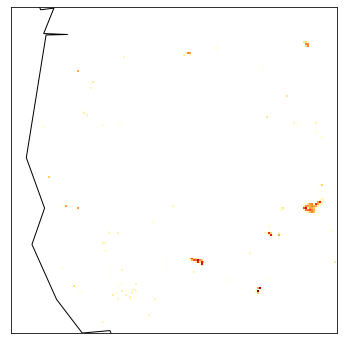

In [12]:
reload(plotter)

try:
    plotter.plotter.plot(['"af_%s".af_in_%d' % (tag_af, i+1)
                     for i,fn in enumerate(af_fnames)], density=True)
except Exception as e:
    print("Got this error: " + str(e))
    print("Didn't work, use QGIS!")
    pass


## 4. Download raster datasets

Check if the extent of raster dataset in the database encloses all fire

In [13]:
reload(downloader)
results_indb = downloader.find_tiles_indb(data='"af_%s"' % tag_af, knd='schema', tag_lct=tag_lct, tag_vcf=tag_vcf)
print(results_indb)
print()


if results_indb['n_need'] == 0:
    print('All fire are is conained in raster')
    print('no need to download/import raster dataset')
    need_to_import_lct = False
    need_to_import_vcf = False
else:
    print('Some fire are not conained in raster')
    print('Will download/import raster dataset')
    need_to_import_lct = (len(results_indb['tiles_missing_lct']) > 0)
    need_to_import_vcf = (len(results_indb['tiles_missing_vcf']) > 0)
    tiles_required_lct = results_indb['tiles_required_lct']
    tiles_required_vcf = results_indb['tiles_required_vcf']

print()
reload(downloader)
need_to_import_regnum = not downloader.find_table_indb('raster', 'rst_%s' % tag_regnum)
if need_to_import_regnum:
    print('Region definiton shapefile will be imported')
else:
    print('no need to import Region definiton shapefile')




{'n_tot': 2535, 'n_ok': 2535, 'n_need': 0, 'tiles_missing_lct': [], 'tiles_missing_vcf': [], 'tiles_required_lct': ['h08v04', 'h08v05', 'h09v04', 'h09v05'], 'tiles_required_vcf': ['h08v04', 'h08v05', 'h09v04', 'h09v05']}

All fire are is conained in raster
no need to download/import raster dataset

no need to import Region definiton shapefile


In [14]:
# Date range of active fire
# TODO use this to set "year_rst" ?
reload(af_import)
af_dates = af_import.get_dates(schema = '"af_%s"'%tag_af, combined=True)
print('first day in AF file:', af_dates.min())
print('last day in AF file:', af_dates.max())

first day in AF file: 2017-07-14
last day in AF file: 2017-07-21


Raster files URL and directories to save data

In [15]:
# all raster downloads are stored in following dir
download_rootdir = '../downloads'

In [16]:
# earthdata's URL for landcover and VCF
is_leap = (year_rst % 4 == 0)
url_lct = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD12Q1.006/%d.01.01/' % year_rst
url_vcf = 'https://e4ftl01.cr.usgs.gov/MOLT/MOD44B.006/%d.03.%02d/' % (year_rst, 5 if is_leap else 6)

ddir_lct = download_rootdir +'/'+ ''.join(urlparse(url_lct)[1:3])
ddir_vcf = download_rootdir +'/'+ ''.join(urlparse(url_vcf)[1:3])

if any((need_to_import_lct, need_to_import_vcf)):
    print('LCT downloads goes to %s' % ddir_lct)
    print('VCF downloads goes to %s' % ddir_vcf)

Download land cover type raster

In [17]:
if need_to_import_lct:
    reload(downloader)
    downloader.download_only_needed(url = url_lct, droot = download_rootdir, tiles=tiles_required_lct)

Verify LCT files' checksum.  If a file is correpted, the file is downloaded again.

In [18]:
if need_to_import_lct:
    downloader.purge_corrupted(ddir = ddir_lct, url=url_lct)

Do similar for vegetation continuous field data

In [19]:
if need_to_import_vcf:
    downloader.download_only_needed(url = url_vcf, droot = download_rootdir, tiles=tiles_required_vcf)

In [20]:
if need_to_import_vcf:
    downloader.purge_corrupted(ddir_vcf, url=url_vcf)

## 5. Import raster datasets

Downloaded files need preprocessing, which is to extract the only raster band needed, and also make coordinate system to be WGS84.  Intermediate files are created in following directories.

In [21]:
workdir_lct = '../proc_rst_%s' % tag_lct
workdir_vcf = '../proc_rst_%s' % tag_vcf
workdir_regnum = '../proc_rst_%s' % tag_regnum

if need_to_import_lct:
    print('LCT preprocessing occurs in %s' % workdir_lct)
if need_to_import_vcf:
    print('VCF preprocessing occurs in %s' % workdir_vcf)
if need_to_import_regnum:
    print('RegNum preprocessing occurs in %s' % workdir_regnum)

### Import land cover type

First grab hdf file names from the download directory

In [22]:
if need_to_import_lct:
    search_string = "%(ddir_lct)s/MCD12Q1.A%(year_rst)s001.h??v??.006.*.hdf" % dict(
        ddir_lct = ddir_lct, year_rst=year_rst)
    fnames_lct = sorted(glob.glob(search_string))
    print('found %d hdf files' % len(fnames_lct) )
    if len(fnames_lct) == 0:
        raise RuntimeError("check if downloads are successful and search string to be correct: %s" % search_string)

The next command performs three tasks, "merge", "resample" and "import".  First two task creates intermediate GeoTiff files in <i>work_dir</i>.  Last task actually import the data into database's <i>raster</i> schema.

In [23]:
if need_to_import_lct:
    reload(rst_import)
    rst_import.main(tag_lct, fnames=fnames_lct, workdir = workdir_lct)

At this point you should able to see the raster in the database using QGIS. 
It is located in schema "raster", table name either one of three, "rst_modlct_YYYY", "o_32_rst_modlct_YYYY", or "o_256_rst_modlct_YYYY", where YYYY is year of raster. "o_" version of raster were for visualization purpose small scale map (greater spatial extent) where as the table without "o_" is the actual data used in processing.

I am also trying to make quick check here creating simple image for QA, but use of GIS tool is encouraged.

Driver : GeoTIFF
Files : ['/vsimem/from_postgis']
Size : (1192, 382)
Coordinate System : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Origin : (-155.6, 50.0)
Pixel Size : (0.0533333344, -0.0533333344)
Metadata : {'AREA_OR_POINT': 'Area'}
OrderedDict([('No Data Value', 255.0), ('Min', None), ('Max', None), ('Scale', 1.0), ('Unit Type', '')])
(382, 1192)


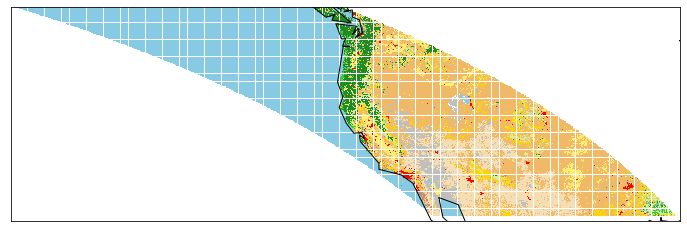

In [24]:
%matplotlib inline
import plotter
reload(plotter)
try:
    plotter.plotter.plot('raster.o_32_rst_%s' % tag_lct, '../code_anaconda/modlct.clr')
except Exception as e:
    try: 
        plotter.plotter.plot('raster.o_256_rst_%s' % tag_lct, '../code_anaconda/modlct.clr')
    
    except Exception as e2:
        print("Got this error: " + str(e))
        print("Didn't work, use QGIS!")
        pass

### Import vegetation continuous fields

Analogous steps repeated for vegetation continous fields.

In [25]:
if need_to_import_vcf:
    # grab hdf file names
    search_string = "%(ddir_vcf)s/MOD44B.A%(year)s065.h??v??.006.*.hdf" % dict(
            ddir_vcf = ddir_vcf, year=year_rst)
    fnames_vcf = sorted(glob.glob(search_string))
    print('found %d hdf files' % len(fnames_vcf) )
    if len(fnames_vcf) == 0:
        raise RuntimeError("check if downloads are successfull and search string to be correct: %s" % search_string)

In [26]:
if need_to_import_vcf:
    reload(rst_import)
    rst_import.main(tag_vcf, fnames=fnames_vcf, workdir = workdir_vcf)

Driver : GeoTIFF
Files : ['/vsimem/from_postgis']
Size : (1192, 382)
Coordinate System : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Origin : (-155.6, 50.0)
Pixel Size : (0.0533333344, -0.0533333344)
Metadata : {'AREA_OR_POINT': 'Area'}
OrderedDict([('No Data Value', 255.0), ('Min', None), ('Max', None), ('Scale', 1.0), ('Unit Type', '')])
OrderedDict([('No Data Value', 255.0), ('Min', None), ('Max', None), ('Scale', 1.0), ('Unit Type', '')])
OrderedDict([('No Data Value', 255.0), ('Min', None), ('Max', None), ('Scale', 1.0), ('Unit Type', '')])
(382, 1192, 3)


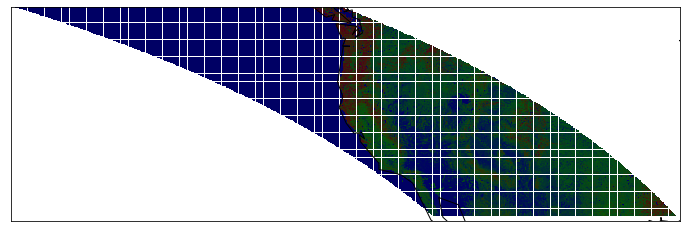

In [27]:
%matplotlib inline
import plotter
reload(plotter)
try:
    plotter.plotter.plot('raster.o_32_rst_%s' % tag_vcf)
except Exception as e:
    try:
        plotter.plotter.plot('raster.o_256_rst_%s' % tag_vcf)
    except Exception as e2:
        print("Got this error: " + str(e))
        print("Didn't work, use QGIS!")
        pass

### Import countries of the world shapefile

This is actually not a raster but vector data of polygons.  But since it serves conceptually similar function as raster (specify attribute for a given geographic location), I treat it as if it is a raster dataset.  

In [28]:
if need_to_import_regnum:
    if not os.path.exists(os.path.join(workdir_regnum, 'All_Countries.shp')):
        subprocess.run(['wget', '-P', workdir_regnum,
                        'https://s3-us-west-2.amazonaws.com/earthlab-finn/All_Countries.zip'], 
                       check=True)
        subprocess.run(['unzip', os.path.join(workdir_regnum, 'All_Countries.zip'), '-d' , workdir_regnum ], 
                       check=True)

In [29]:
if need_to_import_regnum:
    reload(polygon_import)
    polygon_import.main(tag_regnum, shpname = os.path.join(workdir_regnum, 'All_Countries.shp'))

## 6. Process active fire data

### Running "step 1" grouping points

In [30]:
reload(run_step1)
run_step1.main(tag_af, filter_persistent_sources = filter_persistent_sources)

starting prep: 2019-12-22 15:31:09.669402
['psql', '-f', '../code_anaconda/step1_prep_v7m.sql', '-v', 'tag=testOTS_092018', '-v', 'filter_persistent_sources=True']
(datetime.date(2017, 7, 13), datetime.date(2017, 7, 21))
0
starting work 2017-07-13: 2019-12-22 15:31:11.649508
starting work 2017-07-14: 2019-12-22 15:31:13.887053
starting work 2017-07-15: 2019-12-22 15:31:18.626024
starting work 2017-07-16: 2019-12-22 15:31:23.224370
starting work 2017-07-17: 2019-12-22 15:31:25.826519
starting work 2017-07-18: 2019-12-22 15:31:27.869265
starting work 2017-07-19: 2019-12-22 15:31:30.051665
starting work 2017-07-20: 2019-12-22 15:31:32.101594
starting work 2017-07-21: 2019-12-22 15:31:34.119369


### Running "step 2" intersection with raster datasets

In [31]:
reload(run_step2)
run_step2.main(tag_af, rasters)

starting prep: 2019-12-22 15:31:37.503631
(datetime.date(2017, 7, 13), datetime.date(2017, 7, 21))
0
starting work 2017-07-13: 2019-12-22 15:31:38.030355
starting work 2017-07-14: 2019-12-22 15:31:38.647341
starting work 2017-07-15: 2019-12-22 15:31:40.043335
starting work 2017-07-16: 2019-12-22 15:31:42.383504
starting work 2017-07-17: 2019-12-22 15:31:44.388671
starting work 2017-07-18: 2019-12-22 15:31:45.854852
starting work 2017-07-19: 2019-12-22 15:31:46.902864
starting work 2017-07-20: 2019-12-22 15:31:47.821230
starting work 2017-07-21: 2019-12-22 15:31:48.937511


## 7. Export the output

Default output directory is this diretory (where you have this Jupyter Notebook file), and output file has long name of having tag of each datasets.

In [32]:
outdir = '.'
shpname = 'out_{0}_{1}_{2}_{3}.shp'.format(tag_af, tag_lct, tag_vcf, tag_regnum)

In [33]:
schema = 'af_' + tag_af
tblname = 'out_{0}_{1}_{2}'.format(tag_lct, tag_vcf, tag_regnum)
flds = ('v_lct', 'f_lct', 'v_tree', 'v_herb', 'v_bare', 'v_regnum')

In [34]:
reload(export_shp)
export_shp.main(outdir, schema, tblname, flds, shpname)

exporting: ./out_testOTS_092018_modlct_2017_modvcf_2017_regnum.csv ... Done
exporting: ./out_testOTS_092018_modlct_2017_modvcf_2017_regnum.shp ... Done


Summary of processing

In [35]:
reload(run_extra)
run_extra.summarize_log(tag_af)

['psql', '-f', '../code_anaconda/summarize_log.sql', '-v', 'tag=testOTS_092018']
SET
         search_path         
-----------------------------
 "af_testOTS_092018", public
(1 row)

 log_id |     log_event      | log_nrec_change | log_nrec_before | log_nrec_after |      log_time_finish       
--------+--------------------+-----------------+-----------------+----------------+----------------------------
      1 | import af_in_1     |             498 |               0 |            498 | 2019-12-22 15:31:11.20786
      2 | import af_in_2     |            2037 |             498 |           2535 | 2019-12-22 15:31:11.306196
      3 | drop low confience |            -159 |            2535 |           2376 | 2019-12-22 15:31:11.32738
      4 | dup tropics        |               0 |            2376 |           2376 | 2019-12-22 15:31:11.348072
     21 | agg to large       |           -2141 |            2376 |            235 | 2019-12-22 15:31:37.390543
     22 | subdiv             |          

## 8. Disk use summary and clean up (if you wish)

You see summary of disk use and code which optionally cleans up disk use by removing intermediates.

### Point/Polygons

All intermediate datasets for vector processing are stored in the database.  See the usage of individual tables and grand total below.   

In [36]:
qry_af = """SELECT table_schema || '.' || table_name AS table_full_name,
pg_size_pretty(pg_total_relation_size('"' || table_schema || '"."' || table_name || '"')) AS size
FROM information_schema.tables
WHERE table_schema = '%(sch_af)s'   
ORDER BY pg_total_relation_size('"' || table_schema || '"."' || table_name || '"') DESC;""" % dict(
    sch_af=('af_%s' % tag_af),
)

qry_af_tot = """SELECT table_schema,
pg_size_pretty(sum(pg_total_relation_size('"' || table_schema || '"."' || table_name || '"'))) AS size
FROM information_schema.tables
WHERE table_schema = '%(sch_af)s'   
GROUP BY table_schema;""" % dict(
    sch_af=('af_%s' % tag_af),
)


print('Disk use by AF processing intermediate tables inside the database\n')
p = subprocess.run(['psql', '-d', 'finn', '-c', qry_af], stdout=subprocess.PIPE, check=True)
print(p.stdout.decode())

print('Total\n')
p = subprocess.run(['psql', '-d', 'finn', '-c', qry_af_tot], stdout=subprocess.PIPE, check=True)
print(p.stdout.decode())


Disk use by AF processing intermediate tables inside the database

                   table_full_name                    |    size    
------------------------------------------------------+------------
 af_testOTS_092018.work_pnt                           | 1128 kB
 af_testOTS_092018.af_in_2                            | 440 kB
 af_testOTS_092018.out_modlct_2017_modvcf_2017_regnum | 296 kB
 af_testOTS_092018.out_modlct_2017_modvcf_2017        | 288 kB
 af_testOTS_092018.out_modlct_2017                    | 264 kB
 af_testOTS_092018.work_div                           | 248 kB
 af_testOTS_092018.af_in_1                            | 144 kB
 af_testOTS_092018.work_lrg                           | 120 kB
 af_testOTS_092018.tbl_modvcf_2017                    | 80 kB
 af_testOTS_092018.tbl_modlct_2017                    | 72 kB
 af_testOTS_092018.tbl_regnum                         | 56 kB
 af_testOTS_092018.tbl_options                        | 16 kB
 af_testOTS_092018.af_ins                   

If all processing above is successful and you would like to reclaim the diskspace, you can change value of `wipe_intermediate_vector_in_db` defined in the first section of this noetbook to `True`.

In [37]:
# cleans intermediate vector
if wipe_intermediate_vector_in_db == True:
    print(tag_af)
    sch_af = 'af_%s' % tag_af
    print(sch_af)
    qry = 'DROP SCHEMA "%s" CASCADE;' % sch_af
    cmd = ['psql',  '-d', os.environ["PGDATABASE"], '-c', qry]
    subprocess.run(cmd, check=True)

### Raster

Intermediate data for raster dataset are located in three different places.  First the original HDF format file you downloaded from EarthData website.  Seond is GeoTiff format data prepared for importing into PostGIS dataset.  The third is raster dataset inside PostGIS dataset.  Diskspace usage of each are summarized below.

In [38]:
cmd = ['du', '-csh', ddir_lct, ddir_vcf]

p = subprocess.run(cmd, stdout=subprocess.PIPE)
print('Disk use by downloaded raster hdf files')
print(p.stdout.decode())

Disk use by downloaded raster hdf files
0	total



In [39]:
cmd = ['du', '-csh', workdir_lct, workdir_vcf]
p = subprocess.run(cmd, stdout=subprocess.PIPE)
print('Disk use by intermediate raster processing files')
print(p.stdout.decode())

Disk use by intermediate raster processing files
0	total



In [40]:
qry_rst = """SELECT table_schema || '.' || table_name AS table_full_name,
pg_size_pretty(pg_total_relation_size('"' || table_schema || '"."' || table_name || '"')) AS size
FROM information_schema.tables
WHERE table_name ~ '^.*(%(tbl_lct)s|%(tbl_vcf)s)'   
ORDER BY pg_total_relation_size('"' || table_schema || '"."' || table_name || '"') DESC;""" % dict(
    tbl_lct=('rst_%s' % tag_lct),
    tbl_vcf=('rst_%s' % tag_vcf),
)
qry_rst_tot = """SELECT table_schema,
pg_size_pretty(sum(pg_total_relation_size('"' || table_schema || '"."' || table_name || '"'))) AS size
FROM information_schema.tables
WHERE table_name ~ '^.*(%(tbl_lct)s|%(tbl_vcf)s)'   
GROUP BY table_schema;""" % dict(
    sch_af=('af_%s' % tag_af),
    tbl_lct=('rst_%s' % tag_lct),
    tbl_vcf=('rst_%s' % tag_vcf),
)
print('Disk use by raster dataset in the database\n')
p = subprocess.run(['psql', '-d', 'finn', '-c', qry_rst], stdout=subprocess.PIPE, check=True)
print(p.stdout.decode())
print('Total for %(tag_lct)s and %(tag_vcf)s\n' % dict(tag_lct=tag_lct, tag_vcf=tag_vcf))
p = subprocess.run(['psql', '-d', 'finn', '-c', qry_rst_tot], stdout=subprocess.PIPE, check=True)
print(p.stdout.decode())

Disk use by raster dataset in the database

       table_full_name        |  size  
------------------------------+--------
 raster.rst_modvcf_2017       | 239 MB
 raster.rst_modlct_2017       | 10 MB
 raster.o_32_rst_modvcf_2017  | 392 kB
 raster.skel_rst_modvcf_2017  | 88 kB
 raster.skel_rst_modlct_2017  | 88 kB
 raster.o_32_rst_modlct_2017  | 72 kB
 raster.o_256_rst_modvcf_2017 | 32 kB
 raster.o_256_rst_modlct_2017 | 16 kB
(8 rows)


Total for modlct_2017 and modvcf_2017

 table_schema |  size  
--------------+--------
 raster       | 250 MB
(1 row)




In [41]:
# cleans intermediate raster

if wipe_downloaded_hdf == True:
    # ditch entire download directory for the year
    tgts = [ddir_lct, ddir_vcf]
    cmd = ['rm', '-fr', ] + tgts

    subprocess.run(cmd, check=True)
    
if wipe_intermediate_geotiff == True:
    # ditch entire processing directory 
    tgts = [workdir_lct, workdir_vcf]
    cmd = ['rm', '-fr', ] + tgts
    print(cmd)
    subprocess.run(cmd, check=True)
    

if wipe_intermediate_rst_in_db == True:
    # delete each table from the schema 'raster'
    reload(rst_import)
    
    rst_import.drop_tables(tag_lct)
    rst_import.drop_tables(tag_vcf)


In [42]:
import os

os.system('jupyter nbconvert --to html yourNotebook.ipynb')

65280

In [43]:
os.getcwd()


'/home/finn/work_generic'

In [44]:
os.listdir()

['out.step1.o20170721',
 'out.step1.o20170719',
 'out.step1.o20170717',
 'step2_work_modlct_2017_modvcf_2017_regnum_v8b.sql',
 'out.step1.o20170716',
 'out.step1.o20170718',
 'out.step1.o20170720',
 '.DS_Store',
 'sample_output',
 'step2_prep_modlct_2017_modvcf_2017_regnum_v8b.sql',
 'out.step1.o20170714',
 'main_generic.ipynb',
 'out.step1.o20170713',
 'out.step1.o20170715',
 '.ipynb_checkpoints',
 'main_generic.html']

In [47]:
sys.argv

['/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py',
 '-f',
 '/root/.local/share/jupyter/runtime/kernel-1c6997f5-eeae-45fa-a054-d27395b8af27.json']

In [56]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [57]:
print(NOTEBOOK_FULL_PATH)

/work_generic/main_generic.ipynb


In [58]:
os.system('jupyter nbconvert --to html ' + os.path.basename( NOTEBOOK_FULL_PATH))

65280